In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"santhosh0015","key":"1c72ffd5eb7146a935871522ab797af8"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
 ! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                         Online Food Dataset                              3KB  2024-03-02 18:50:30          21867        441  0.9411765        
sukhmandeepsinghbrar/housing-price-dataset                  Housing Price Dataset                          780KB  2024-04-04 19:45:43            875         24  1.0              
datascientist97/e-commerece-sales-data-2024                 E-commerece Sales Data 2024                      6MB  2024-04-05 12:32:58            646         25  1.0              
mohdshahnawazaadil/restaurant-dataset                       Restaurant Dataset                           

In [ ]:
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

 23% 5.00M/21.8M [00:00<00:00, 33.1MB/s]
100% 21.8M/21.8M [00:00<00:00, 99.6MB/s]


In [ ]:
!unzip satellite-image-classification.zip

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import torch.utils.data as data

In [ ]:
dataset_dir = '/content/data'
labels = os.listdir(dataset_dir)
labels

In [ ]:
for label in labels:
    print(label, len(os.listdir(dataset_dir+'/'+label)))

water 1500
green_area 1500
desert 1131
cloudy 1500


In [ ]:
label_counts = {}

for label in labels:
    label_dir = os.path.join(dataset_dir, label)
    num_images = len(os.listdir(label_dir))
    label_counts[label] = num_images

total_count = sum(label_counts.values())
print("Total image count:", total_count)

Total image count: 5631


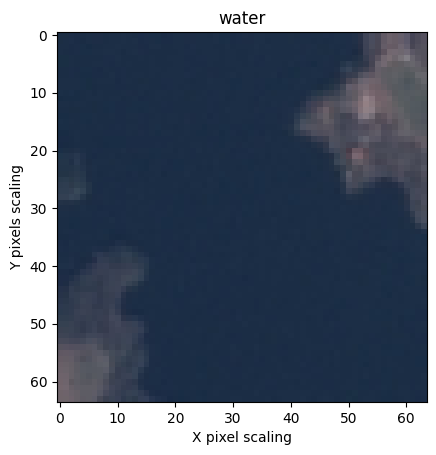

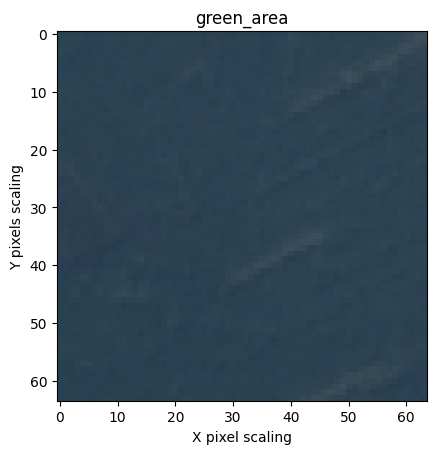

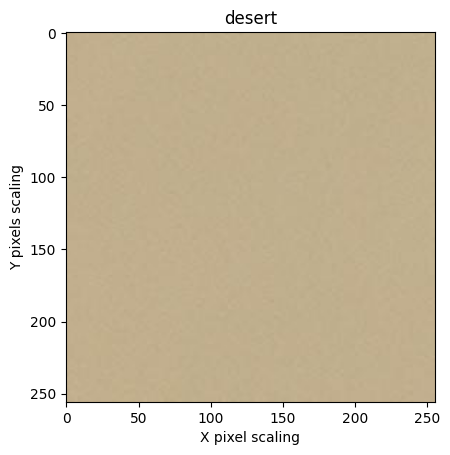

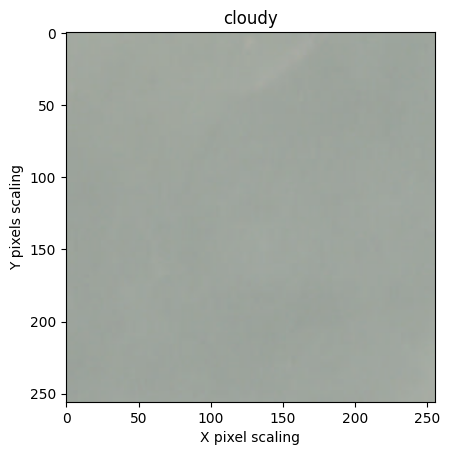

In [ ]:
for label in labels:
    path = os.listdir(dataset_dir + '/' + label)
    img = dataset_dir + '/' + label + '/' + path[1]
    plt.title(label)
    plt.xlabel("X pixel scaling")
    plt.ylabel("Y pixels scaling")
    image = mpimg.imread(img)
    plt.imshow(image)
    plt.show()

In [ ]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding=10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

In [ ]:
dataset = datasets.ImageFolder(dataset_dir,transform=test_transforms)

In [ ]:
#VALID_RATIO = 6:2:2

n_train_examples = 3379
n_valid_examples = 1126
n_test_examples = 1126

train_data, valid_data, test_data = data.random_split(dataset,[n_train_examples, n_valid_examples, n_test_examples])

In [ ]:
print("Total number of images: ", len(dataset))
print("Number of train data:", len(train_data))
print("Number of validation data:", len(valid_data))
print("Number of test data:", len(test_data))

Total number of images:  5631
Number of train data: 3379
Number of validation data: 1126
Number of test data: 1126


In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image


def plot_images(images, labels, classes, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

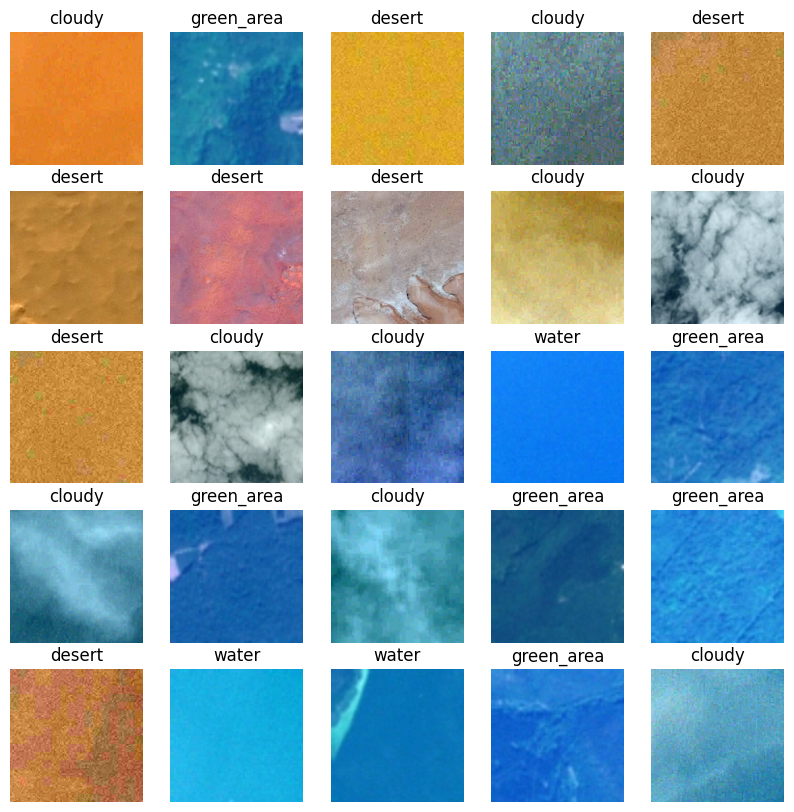

In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = train_data.dataset.classes

plot_images(images, labels, classes)

In [ ]:
batch_size = 16
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_data, batch_size, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_data, batch_size, num_workers=2, pin_memory=True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


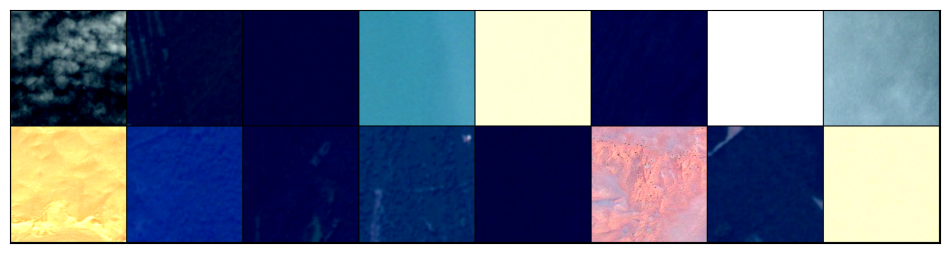

In [ ]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

In [ ]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([16, 3, 224, 224])


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    # training
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    #validation
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc} # output the loss

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        # output data for eacj epoch
        print("Epoch {}, last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch + 1, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.AdaptiveAvgPool2d(2))
    return nn.Sequential(*layers)

In [ ]:
import torchvision.models as models

class ResNet18(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()

        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, xb):
        out = self.model(xb)
        return out

In [ ]:
model = to_device(ResNet18(num_classes=4),device)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 46.9MB/s]


ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]

In [ ]:
epochs = 50 # number of epochs
#epochs = 100
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam # Optimizer

In [ ]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch 1, last_lr: 0.00050, train_loss: 0.1241, val_loss: 0.0563, val_acc: 0.9859
Epoch 2, last_lr: 0.00081, train_loss: 0.1218, val_loss: 0.0482, val_acc: 0.9868
Epoch 3, last_lr: 0.00131, train_loss: 0.0870, val_loss: 0.0768, val_acc: 0.9710
Epoch 4, last_lr: 0.00199, train_loss: 0.1220, val_loss: 0.3032, val_acc: 0.8210
Epoch 5, last_lr: 0.00280, train_loss: 0.1441, val_loss: 2.2776, val_acc: 0.7277
Epoch 6, last_lr: 0.00371, train_loss: 0.1315, val_loss: 0.5420, val_acc: 0.8084
Epoch 7, last_lr: 0.00470, train_loss: 0.1700, val_loss: 0.1517, val_acc: 0.9313


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy');

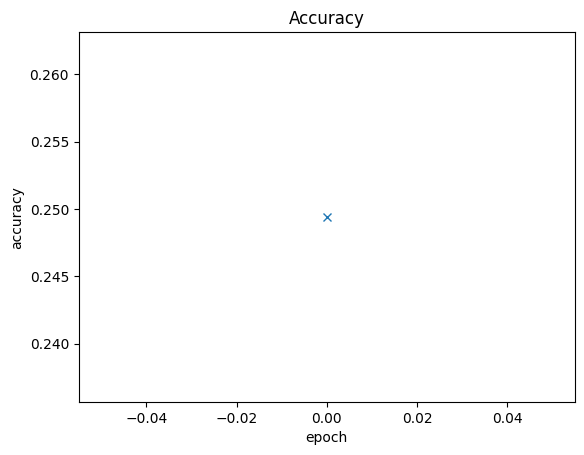

In [ ]:
 plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss');

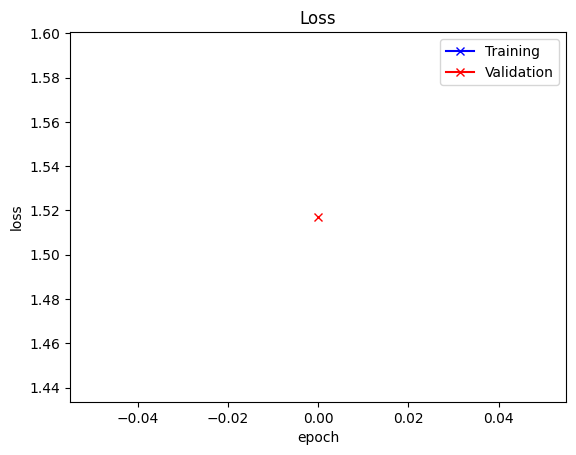

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate');

In [ ]:
plot_lrs(history)

In [ ]:
# predict the label with a label
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

In [ ]:
def model_test():
    acc_count = 0;
    err_count = 0;

    for i in range(0, len(test_data)):

        img = test_data[i][0];
        label = test_data[i][1];

        predict_class = predict_image(img, model);
        real_class = dataset.classes[label]
        print("Test image", i+1, end = " , ")
        if predict_class == real_class:
            print("Result: Correct ", end = " ")
            acc_count += 1
        else:
            print("Result: Wrong", end = " ")
            err_count += 1
        print( "Predicted:", predict_class, ", Real Class:", real_class)

    total = acc_count + err_count
    print("=============================FINAL RESULT==============================")

    print ("Total image in test set:", total)
    print("Correct:", acc_count)
    print("Wrong:", err_count)
    print("Correct Rate:", 100*acc_count/total , "%")
    print("=======================================================================")

    # draw diagram
    y = np.array([acc_count, err_count])

    plt.pie(y,
        labels=['Correct','Wrong'],
        colors=["#65a479", "#a564c9"],
        autopct='%.2f%%',
#         explode=(0.2, 0)
       )
    plt.title("Test Result")
    plt.show()

model_test()